# Il modello di Ising

Questo notebook implementa il modello di Ising 2D in un reticolo quadrato. Si assume il contatto con un serbatoio di calore esterno, tale da mantenere la temperatura costante nel reticolo e da potersi considerare nell'ensemble canonico. L'evoluzione temporale sarà simulata attraverso l'algoritmo Metropolis, contenuto in una subroutine dentro un modulo esterno in fortran, che effettuerà una serie di spin flip ad ogni step temporale. Si fissa inoltre $J=1$ e $k_B=1$.

I processi di inizializzazione, evoluzione temporale e calcolo/registrazione delle osservabili è automatizzato attraverso la definizione della classe $\texttt{Ising}$:
- Nella funzione $\texttt{initialize}$ viene inizializzato il modello di Ising. Si calcola magnetizzazione ed energia iniziali (si utilizza la funzione $\texttt{calc\_energy}$), la configurazione di spin iniziale desiderata a partire dall'attributo $\texttt{spin\_init}$ (si utilizza la funzione $\texttt{spin\_config}$) e l'array di fattori di Boltzmann corrispondenti alle variazioni di energia possibili $dE=-8,-4,0,4,8$. Si inizializzano inoltre le variabili globali del modulo in fortran, al quale ci si interfaccia tramite $\texttt{f2py-jit}$. 
- L'evoluzione temporale avviene in $\texttt{metro\_step}$, in cui si eseguono un numero $\texttt{N\_step}$ di passi, determinato in input, dell'algoritmo Metropolis. A ciascuno step corrisponde un'esecuzione di una subroutine in fortran consistente in $N=L^2$ spin flip, effettuati uno dopo l'altro in modo casuale o ordinato (a seconda dell'attributo $\texttt{update\_spin}$). Ogni step risulta inoltre in un valore di energia e magnetizzazione, i quali sono registrati nella lista $\texttt{data}$ nel caso in cui $\texttt{store=True}$.
- In $\texttt{ising\_driver}$ si automatizza inizializzazione ed evoluzione del modello, prima per rilassare il modello fino all'equilibrio termodinamico ($\texttt{N\_eq}$ step) e poi per evolvere il sistema e studiarne il comportamento una volta all'equilibrio ($\texttt{N\_mcs}$ step). Si pensa inoltre a registrare il contenuto della lista $\texttt{data}$ in un file esterno.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML
from f2py_jit import jit

class Ising:

    '''
    This class implements 
    the 2D Ising model
    on a square lattice
    '''
    
    def __init__(self,L,T,N_eq,N_mcs,boundary='pbc',spin_init='random',update_spin='random',sample_equi=False,sample_spin=False,print_stats=True,data_filename='EM_data.txt',spin_filename='spin_data.txt',f90_filename='ising.f90'):

        '''
        Initialise the Ising model
        '''

        self.L = L
        self.N = L**2
        self.T = T
        self.E = None
        self.M = None
        self.E_N_av = None
        self.M_N_av = None
        self.seed_number = 18261
        self.rng = np.random.default_rng(seed=self.seed_number)
        self.boundary = boundary
        self.spin = None
        self.spin_init = spin_init
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.N_eq = N_eq
        self.N_mcs = N_mcs
        self.update_spin = update_spin
        self.data = []
        self.spin_data = []
        self.ar = None
        self.sample_equi = sample_equi
        self.sample_spin = sample_spin
        self.c_heat = None
        self.chi_mag = None
        self.print_stats = print_stats
        self.data_filename = data_filename 
        self.spin_filename = spin_filename
        self.f90_filename = f90_filename
        self.module = jit(self.f90_filename).module
    

    def spin_config(self):

        '''
        Initialise the spin configuration
        '''

        # Random configuration (uniform +1 and -1 distribution)
        rnd = self.rng.random((self.L,self.L))
        if self.spin_init == 'random':
            return np.asfortranarray(np.where(rnd < 0.5, -1, 1).astype(np.int32))
        # Ferromagnetic state (all spin ups)
        elif self.spin_init == 'fm':
            return np.ones((self.L,self.L), dtype=np.int32, order='F')
        # Antiferromagnetic state (alternated between spin up and spin down)
        elif self.spin_init == 'afm':
            return np.asfortranarray(((np.indices((self.L, self.L)).sum(axis=0) % 2) * 2 - 1).astype(np.int32))
        # Left side has spin up, right has spin down
        elif self.spin_init == 'half':
            spins = np.ones((self.L, self.L), dtype=np.int32, order='F')
            spins[:, self.L//2:] = np.int32(-1)
            return spins
        else:
            raise ValueError("Invalid value for spin_init. Possible labels are 'up', 'down' and 'random' (default is 'random')")
    

    def calc_energy(self):

        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''

        E = 0
        for j in range(self.L-1):
            for i in range(self.L-1):
                up,right = j+1,i+1
                E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])

        if self.boundary == 'pbc':
            up,right = 0,0
            E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E
    

    def initialize(self):

        '''
        Initialization of the system:
        - E, M and fortran global variables are initialized
        - Metropolis' probability coefficients stored in
          an array to be sent to the fortran module
        - spins are configured following the instructions
          in spin_init
        '''

        # Fortran variables
        self.module.l = self.L
        self.module.n = self.N
        self.module.accept = self.acc
        self.module.put_seed(self.seed_number)
        self.module.boundary = self.boundary

        self.module.w = np.zeros(17, dtype=np.float64)
        for dE in range(-8,8+1,4):
            self.module.w[dE+8] = np.exp(-1.0*dE/self.T)

        # Spin initialization
        self.spin = self.spin_config()
        self.spin_data.append(self.spin.copy())

        # Energy and magnetization
        self.module.m = np.sum(self.spin)
        self.module.e = self.calc_energy()
        self.data.append((self.module.e.copy(),self.module.m.copy()))


    def metro_driver(self, N_step, store_data=True, store_spin=False):

        '''
        Run N Metropolis steps of spin flip dynamics'
        '''

        # Choose spin update method and the respective fortran subroutine
        if self.update_spin == 'random':
            metro_sub = self.module.metro_step
        elif self.update_spin == 'ordered':
            metro_sub = self.module.metro_step_ordered

        # Evolve for N_step
        for _ in range(N_step):
            metro_sub(self.spin)
            self.counter += self.N
            self.E = self.module.e.copy()
            self.M = self.module.m.copy()
            if store_data:
                self.data.append((self.E,self.M)) 
            if store_spin:
                self.spin_data.append(self.spin.copy()) 
            

    def ising_driver(self):

        '''
        Main driver for the Monte Carlo
        '''

        # Equilibration + evolution at equilibrium
        self.initialize()
        self.metro_driver(self.N_eq, store_data=self.sample_equi, store_spin=self.sample_spin)
        self.metro_driver(self.N_mcs, store_spin=self.sample_spin)

        # Save energy and magnetization data
        self.data = np.array(self.data)
        np.savetxt(self.data_filename, self.data)

        # Save spin data
        if self.sample_spin == True:
            #self.spin_data = np.array(self.spin_data)
            with open(self.spin_filename, "w") as file:
                for frame in self.spin_data:
                    np.savetxt(file, np.array(frame), fmt="%d")
                    file.write("\n")
    

    @staticmethod
    def plot_spin(spin):
        
        '''
        Plot final 2d spin configuration
        '''
        
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))

        col_dict = {-1: "orange",
            1: "green"}
        cmap = ListedColormap([col_dict[k] for k in col_dict.keys()])
        scatter = plt.scatter(x,y,c=spin[x,y],cmap=cmap,label='spin')

        cbar = plt.colorbar(scatter, ticks=[-1,1])
        cbar.set_label("Spin")
        plt.title('Spin configuration')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    
    @staticmethod
    def animate_spin(file_in, file_out):
        
        '''
        Plot final 2d spin configuration
        '''

        # Opens file with spin configurations
        with open(file_in, "r") as file:
            raw_data = file.read().strip().split("\n\n")
        
        frames = [np.array([list(map(int, row.split())) for row in frame.split("\n")]) for frame in raw_data]
        
        x,y = np.meshgrid(range(frames[0].shape[0]), range(frames[0].shape[1]))

        col_dict = {-1: "orange",
            1: "green"}
        cmap = ListedColormap([col_dict[k] for k in col_dict.keys()])
        fig, ax = plt.subplots()
        scatter = ax.scatter(x,y,c=frames[0][x,y],cmap=cmap,label='spin')

        cbar = fig.colorbar(scatter, ax=ax, ticks=[-1, 1])
        cbar.set_label("Spin")
        ax.set_title('Spin configuration')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Updates the animation at each frame
        def update(frame):
            ax.set_title(fr"Spin configuration at step ${frame}$")
            scatter.set_array(frames[frame][x,y].flatten())
            return scatter,

        ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=80)

        plt.close(fig)

        # Saves animation in the current directory
        ani.save(file_out, writer="pillow")


    @staticmethod
    def calc_autocorr(a,N):

        '''
        Autocorrelation function
        '''

        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            avg_1 = np.average(a[:-k])
            avg_2 = np.average(a[k:])
            var_1 = np.var(a[:-k])
            var_2 = np.var(a[k:])
            res[k] = (c_k-avg_1*avg_2)/np.sqrt(var_1*var_2)
        return res
    
    
    def get_stats(self):

        '''
        Calculate, store and print 
        statistical quantities
        '''

        self.acc = self.module.accept
        self.ar = self.acc*1.0/self.counter
        self.E_N_av = np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2) - (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2) - (self.M_N_av*self.N)**2)/(self.T**2*self.N)

        if self.print_stats == True:
            print("Total number of steps run = {}".format(self.counter/self.N))
            print("Acceptance ratio = {}".format(self.ar))
            print("Temperature = {}".format(self.T))
            print("<E/N> = {}".format(self.E_N_av))
            print("<M/N> = {}".format(self.M_N_av))
            print("specific heat = {}".format(self.c_heat))
            print("magnetic susceptibility = {}".format(self.chi_mag))

Si testa l'algoritmo registrando il tempo di esecuzione di ogni riga in $\texttt{initialize}$ e $\texttt{metro\_step}$. Si fa in modo di comprimere le parti di codice più costose dal punto di vista computazionale all'interno delle subroutine nel modulo fortran.

In [24]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=2000, sample_equi=True)
%load_ext line_profiler
%lprun -f ising.initialize ising.initialize()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.0133223 s
File: /tmp/ipykernel_23269/3268526231.py
Function: initialize at line 98

Line #      Hits         Time  Per Hit   % Time  Line Contents
    98                                               def initialize(self):
    99                                           
   100                                                   '''
   101                                                   Initialization of the system:
   102                                                   - E, M and fortran global variables are initialized
   103                                                   - Metropolis' probability coefficients stored in
   104                                                     an array to be sent to the fortran module
   105                                                   - spins are configured following the instructions
   106                                                     in spin_init
   107                                            

In [25]:
%lprun -f ising.metro_driver ising.metro_driver(N_step=1000)

Timer unit: 1e-09 s

Total time: 0.113562 s
File: /tmp/ipykernel_23269/3268526231.py
Function: metro_driver at line 130

Line #      Hits         Time  Per Hit   % Time  Line Contents
   130                                               def metro_driver(self, N_step, store_data=True, store_spin=False):
   131                                           
   132                                                   '''
   133                                                   Run N Metropolis steps of spin flip dynamics'
   134                                                   '''
   135                                           
   136                                                   # Choose spin update method and the respective fortran subroutine
   137         1       4400.0   4400.0      0.0          if self.update_spin == 'random':
   138         1       5200.0   5200.0      0.0              metro_sub = self.module.metro_step
   139                                                   elif 

---

# Dipendenza del modello dalla temperatura

Si esegue di seguito l'algoritmo inizializzando la classe $\texttt{Ising}$ ed eseguendo rispettivamente $\texttt{initialize}$, $\texttt{ising\_driver}$, $\texttt{get\_stats}$ (per il calcolo di $\langle E\rangle/N$, $\langle M\rangle/N$, $c_V$ e $\chi$) e $\texttt{plot\_spin}$ (per rappresentare la configurazione finale di spin). Si inizia scegliendo $\texttt{L=30}$, $\texttt{N\_eq=N\_mcs=1000}$ e $\texttt{T=2}$. Si graficano inoltre energia e magnetizzazione per numero di particelle nel corso della dinamica in modo da visualizzare il rilassamento del sistema e le fluttuazioni dello stesso all'equilibrio.

La stessa analisi di effettua alzando la temperatura a $\texttt{T=3}$: mentre dai risultati precedenti si osservava l'allineamento tra spin a fine evoluzione, in questo caso la dinamica favorisce una configurazione disordinata di spin. Si evince quindi la presenza di una transizione di fase tra $2J/k_B$ e $3J/k_B$, in accordo con il valore $T_c=2.269J/k_B$ noto analiticamente. Una notevole differenza si nota anche nel numero di step richiesto per raggiungere l'equilibrio termodinamico, molto più corto ponendosi nella fase disordinata.

Total number of steps run = 3000.0
Acceptance ratio = 0.08302814814814814
Temperature = 2
<E/N> = -1.7441757346953881
<M/N> = -0.8845747279591384
specific heat = 1.9627541291964654
magnetic susceptibility = 3.832465645697537


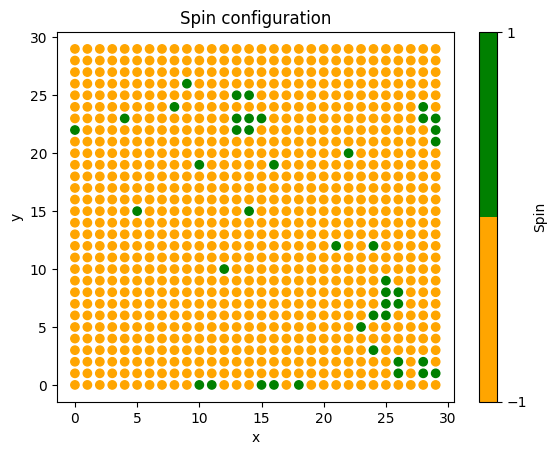

In [26]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=2000, spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

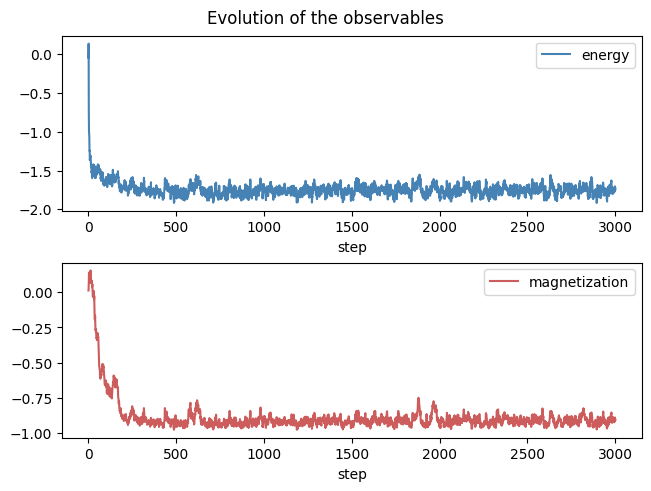

In [27]:
fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

Total number of steps run = 3000.0
Acceptance ratio = 0.46129444444444445
Temperature = 3
<E/N> = -0.8271382041601895
<M/N> = 0.007871789177585313
specific heat = 0.441321889732355
magnetic susceptibility = 1.3044928281965933


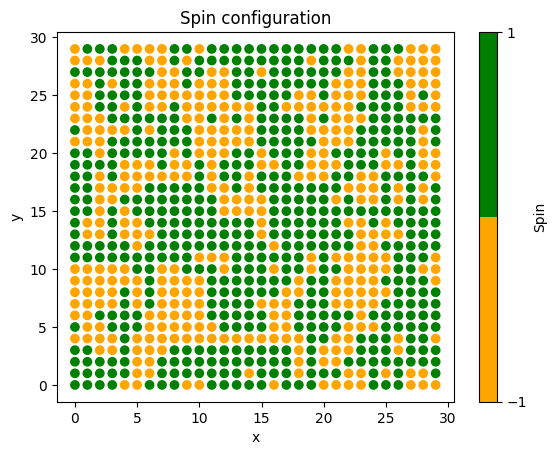

In [28]:
ising = Ising(L=30, T=3, N_eq=1000, N_mcs=2000, spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

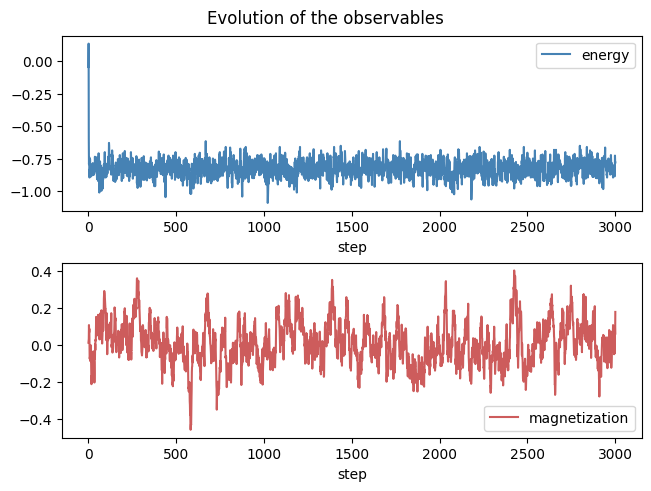

In [29]:
fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

---

# Dipendenza del modello dalle condizioni iniziali

Sebbene le condizioni iniziali scelte per il modello non dovrebbero influenzare lo stato termodinamico finale del sistema, ci si può aspettare che esse possano invece agire su come tale stato venga raggiunto. Si mostra di seguito l'evoluzione temporale della densità di energia per numero di siti per 4 scelte di configurazioni iniziali di spin:
- $\texttt{'random'}$: il microstato iniziale viene scelto randomicamente attraverso una distruzione di probabilità uniforme con variabili $+1$ e $-1$;
- $\texttt{'fm'}$: il microstato iniziale è uno stato ferromagnetico con ogni spin fissato a $+1$;
- $\texttt{'afm'}$: il microstato iniziale è uno statp antiferromagnetico, tale che ogni spin sia opposto rispetto ai propri primi vicini;
- $\texttt{'half'}$: il microstato iniziale ha la metà sinistra spin down e la metà destra spin up.

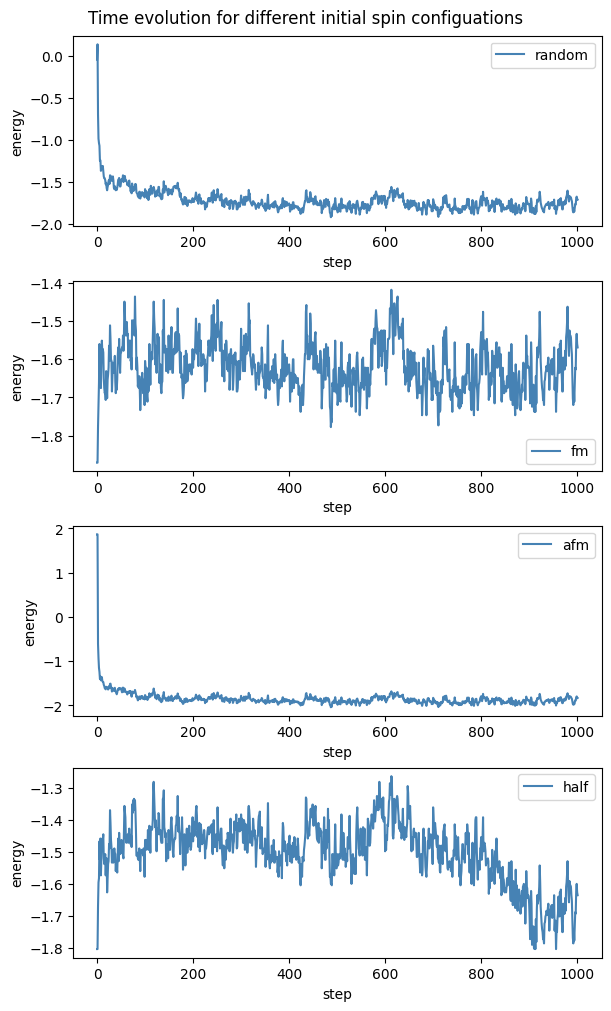

In [30]:
configurations = ['random', 'fm', 'afm', 'half']

fig, axs = plt.subplots(nrows=4, layout='constrained', figsize=(6,10))
fig.suptitle('Time evolution for different initial spin configuations')

for i in range(4):
    ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init=configurations[i], sample_equi=True)
    ising.initialize()
    ising.ising_driver()
    axs[i].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label=f'{configurations[i]}')
    axs[i].legend()
    axs[i].set_xlabel('step')
    axs[i].set_ylabel('energy')

---

# Quantità termodinamiche al punto critico

Si calcolano di seguito alcune grandezze termodinamiche al variare della temperatura. In particolare ci si interessa a energia e magnetizzazione per numero di siti, al calore specifico e alla suscettività magnetica, tutte calcolate a partire dai valori medi di $E$ e $M$ sugli step al di fuori della fase di rilassamento del modello:

$$
\epsilon = \frac{\langle E\rangle}{N}
\quad,\quad
m = \frac{\langle M\rangle}{N}
\quad,\quad
c_V = \frac{\langle E^2\rangle - \langle E\rangle^2}{T^2 N}
\quad,\quad
\chi = \frac{\langle M^2\rangle - \langle M\rangle^2}{T^2 N}
$$

L'intensività di $c_V$ e $\chi$ è assicurata all'equilibrio termodinamico poiché le varianze dell'energia e della magnetizzazione scalano linearmente nelle variabili estensive. Inoltre entrambe possono essere espresse a partire da derivate seconde dell'energia (rispetto a $S$ o rispetto a $h$): avendo fissato $h=0$ e essendoci interessati sull'andamento delle quantità termodinamiche rispetto a $T$, si potrà calcolare il calore specifico isocoro calcolando la seguente derivata in modo numerico:

$$
c_V = \frac{\partial\langle E\rangle}{\partial T}
$$

Ripetendo la stessa analisi per $L=4$ si nota come le non analiticità nelle variabili termodinamiche svaniscono. Ciò è dovuto all'assenza di fenomeni critici per sistemi non al limite termodinamico.

In [31]:
T_list = np.linspace(1.5,4,30)

res=[]
for T in T_list:
    ising = Ising(L=30, T=T, N_eq=1000, N_mcs=100000, spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

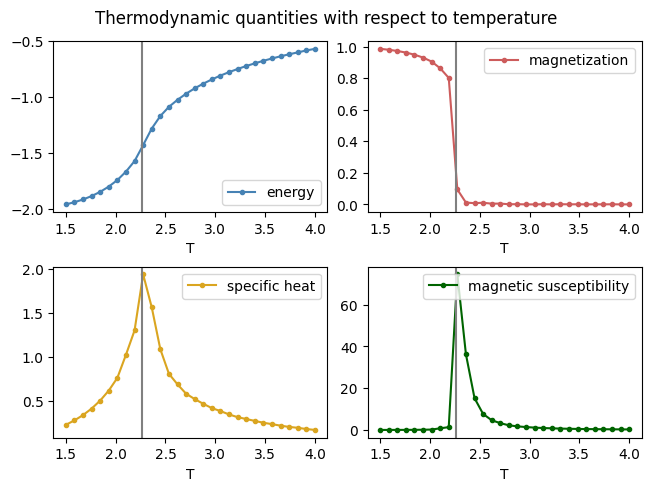

In [32]:
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    fig.suptitle('Thermodynamic quantities with respect to temperature')
    axs[0,0].plot(T_list,res[:,0],'-o',ms=3,c='steelblue',label='energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'-o',ms=3,c='indianred',label='magnetization')
    axs[1,0].plot(T_list,res[:,2],'-o',ms=3,c='goldenrod',label='specific heat')
    axs[1,1].plot(T_list,res[:,3],'-o',ms=3,c='darkgreen',label='magnetic susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.axvline(x=2.26,c='grey')

plot_res(T_list,res)

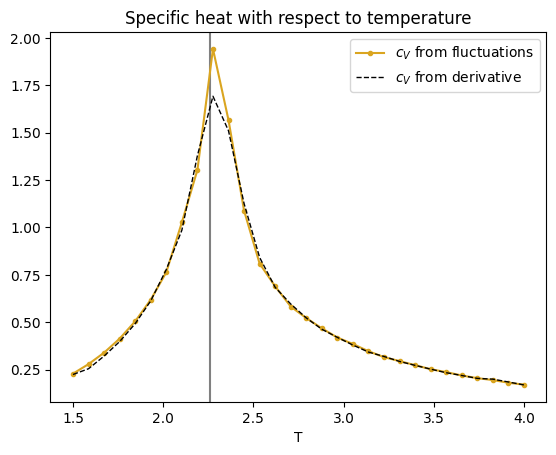

In [33]:
d2E_dT2 = np.gradient(res[:,0],np.array(T_list))

plt.xlabel('T')
plt.axvline(x=2.26,c='grey')
plt.title('Specific heat with respect to temperature')
plt.plot(T_list,res[:,2],'-o',c='goldenrod',ms=3,label=r'$c_V$ from fluctuations')
plt.plot(T_list, d2E_dT2,'--',c='k',lw=1,label=r'$c_V$ from derivative')
plt.legend()

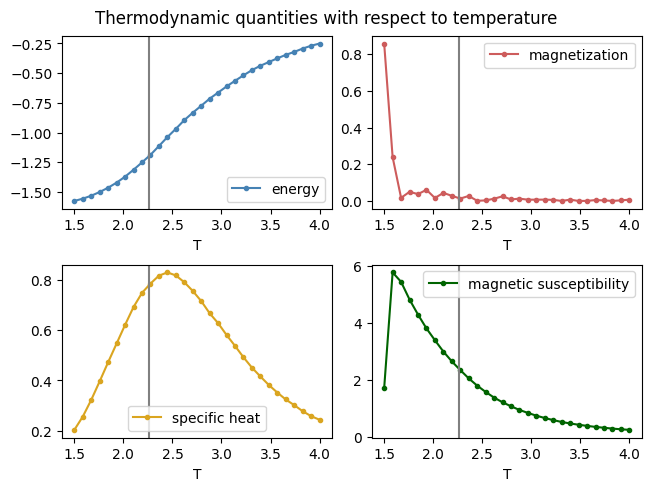

In [34]:
res=[]
for T in T_list:
    ising = Ising(L=4, T=T, N_eq=1000, N_mcs=100000, spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

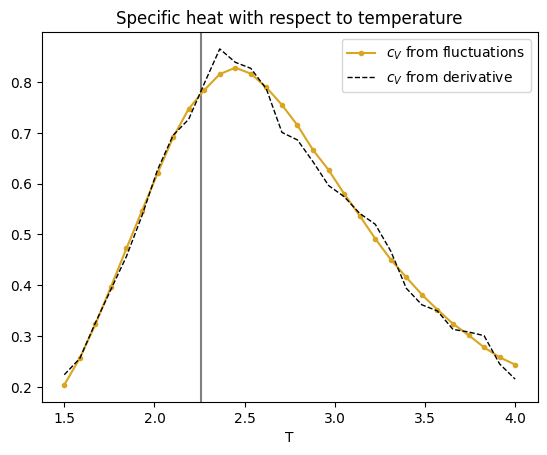

In [35]:
d2E_dT2 = np.gradient(res[:,0],np.array(T_list))

plt.xlabel('T')
plt.axvline(x=2.26,c='grey')
plt.title('Specific heat with respect to temperature')
plt.plot(T_list,res[:,2],'-o',c='goldenrod',ms=3,label=r'$c_V$ from fluctuations')
plt.plot(T_list, d2E_dT2,'--',c='k',lw=1,label=r'$c_V$ from derivative')
plt.legend()

---

# Open boundary conditions

La precedente analisi è stata compiuta fissando delle condizioni al contorno periodiche. Alternativamente si può fissare $\texttt{boundary='obc'}$ come attributo della classe $\texttt{Ising}$, passando a delle condizioni al contorno aperte. Ciò renderà molto più visibili gli effetti di superfici nel sistema, i quali saranno sempre più rilevanti con l'abbassarsi delle dimensioni del sistema.

Total number of steps run = 1500.0
Acceptance ratio = 0.12790148148148148
Temperature = 2
<E/N> = -1.3829649356413671
<M/N> = 0.6049874241751738
specific heat = 1.6611719344863538
magnetic susceptibility = 2.0419258225310637


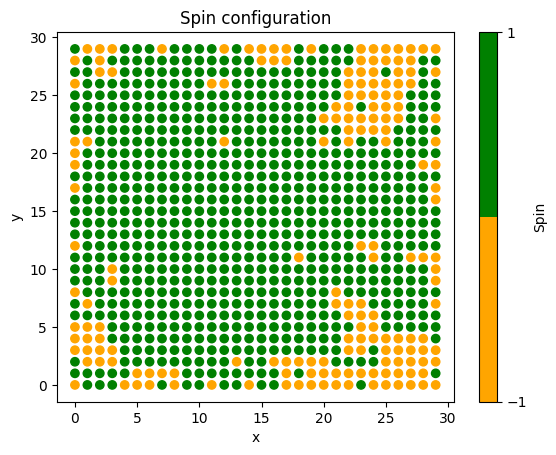

In [36]:
ising = Ising(L=30, T=2, N_eq=500, N_mcs=1000, boundary='obc', spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

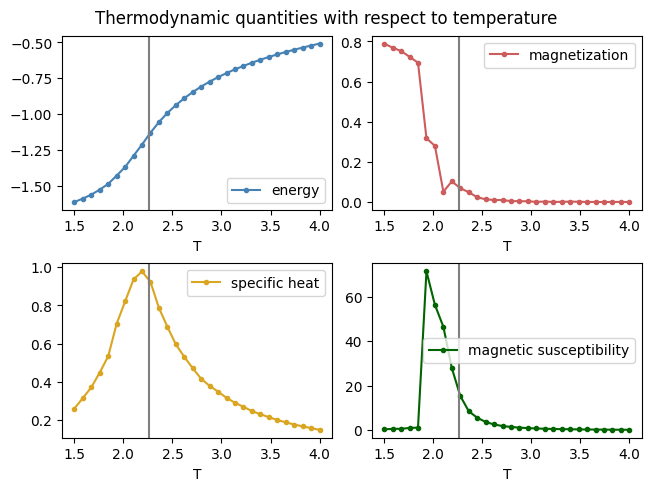

In [37]:
res=[]
for T in T_list:
    ising = Ising(L=30, T=T, N_eq=1000, N_mcs=100000, boundary='obc', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

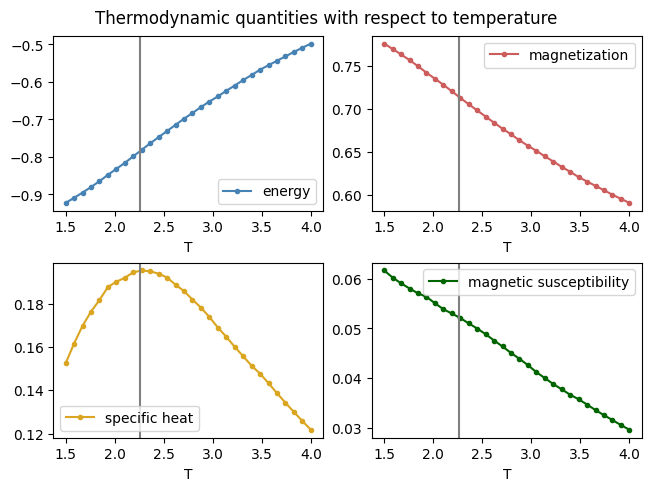

In [38]:
res=[]
for T in T_list:
    ising = Ising(L=4, T=T, N_eq=1000, N_mcs=100000, boundary='obc', spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

---

# Ordine degli spin flip

Fissando l'attributo $\texttt{update\_spin}$ si può controllare come, ad ogni step dell'algoritmo Metropolis, gli spin vengano invertiti:
- $\texttt{update\_spin='random'}$ (default): Ad ogni step corrispondono $N$ spin flip in ordine casuale;
- $\texttt{update\_spin='ordered'}$: Ad ogni step corrispondono $N$ spin flip in ordine da $1$ a $N$.

Osservando l'evoluzione delle osservabili si nota in genere un tempo di rilassamento minore nel caso in cui gli spin flip avvengano in ordine. Ciò è probabilmente dovuto alla possibilità di avere $2$ spin flip nello stesso sito nel primo caso, il che risulta in un rallentamento della dinamica.

Si calcolano inoltre le funzioni di autocorrelazione per $E$ e $M$, le quali mostrano un tempo di correlazione all'equilibrio molto basso indipendentemente dal valore di $\texttt{update\_spin}$.

$$
\mathcal{C}_E(k) = \frac{\langle E(t)E(t+k)\rangle - \langle E(t)\rangle\langle E(t+k)\rangle}{\sqrt{\langle\Delta^2E(t)\rangle\langle \Delta^2E(t+k)\rangle}}
\quad,\quad
\mathcal{C}_M(k) = \frac{\langle M(t)M(t+k)\rangle - \langle M(t)\rangle\langle M(t+k)\rangle}{\sqrt{\langle\Delta^2M(t)\rangle\langle \Delta^2M(t+k)\rangle}}
$$

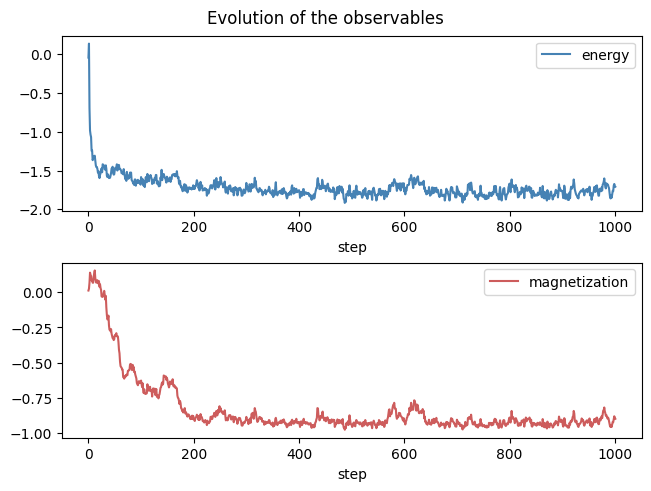

In [39]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init='random', update_spin='random', sample_equi=True, print_stats=False)
ising.initialize()
ising.ising_driver()

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

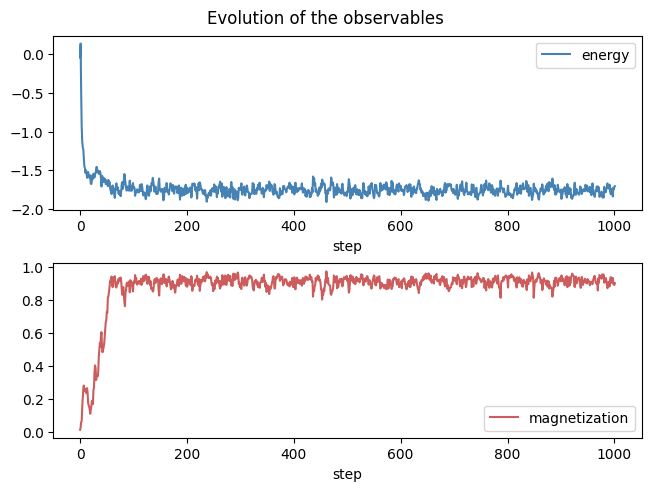

In [40]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init='random', update_spin='ordered', sample_equi=True, print_stats=False)
ising.initialize()
ising.ising_driver()

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

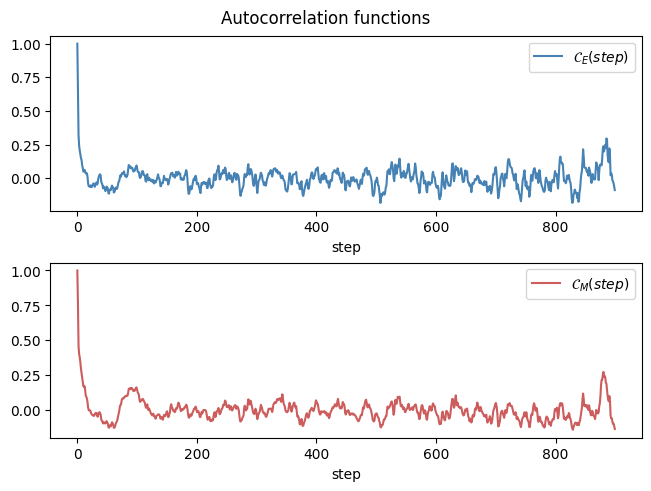

In [41]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=1000, spin_init='random', update_spin='random', sample_equi=False, print_stats=False)
ising.initialize()
ising.ising_driver()

autocorrE = ising.calc_autocorr(ising.data[:,0], ising.N)
autocorrM = ising.calc_autocorr(ising.data[:,1], ising.N)

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Autocorrelation functions')
axs[0].plot(autocorrE, '-', c='steelblue', label=r'$\mathcal{C}_E(step)$')
axs[1].plot(autocorrM, '-', c='indianred', label=r'$\mathcal{C}_M(step)$')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

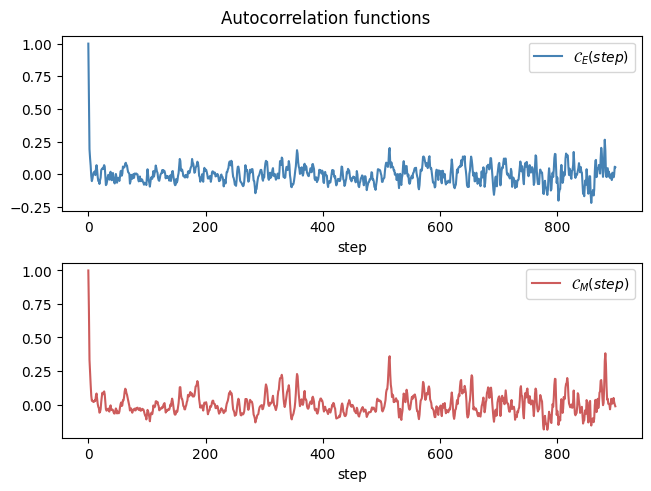

In [42]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=1000, spin_init='random', update_spin='ordered', sample_equi=False, print_stats=False)
ising.initialize()
ising.ising_driver()

autocorrE = ising.calc_autocorr(ising.data[:,0], ising.N)
autocorrM = ising.calc_autocorr(ising.data[:,1], ising.N)

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Autocorrelation functions')
axs[0].plot(autocorrE, '-', c='steelblue', label=r'$\mathcal{C}_E(step)$')
axs[1].plot(autocorrM, '-', c='indianred', label=r'$\mathcal{C}_M(step)$')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

---

# Animazione dell'evoluzione temporale

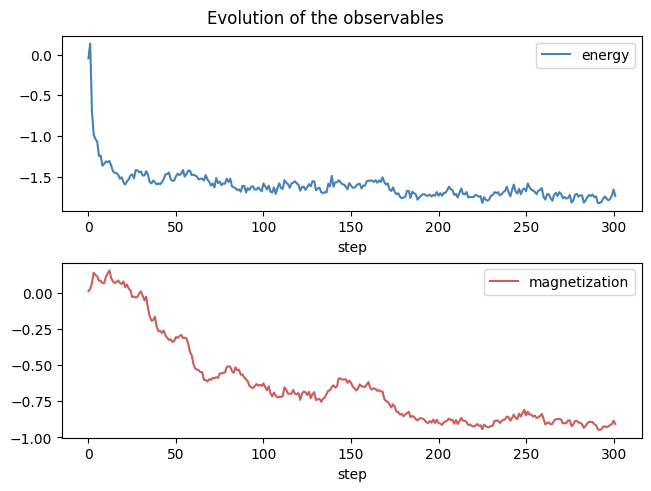

In [43]:
ising = Ising(L=30, T=2, N_eq=300, N_mcs=0, spin_init='random', sample_equi=True, sample_spin=True)
ising.initialize()
ising.ising_driver()
ising.animate_spin(ising.spin_filename, 'spin_anim_ordered.gif')

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

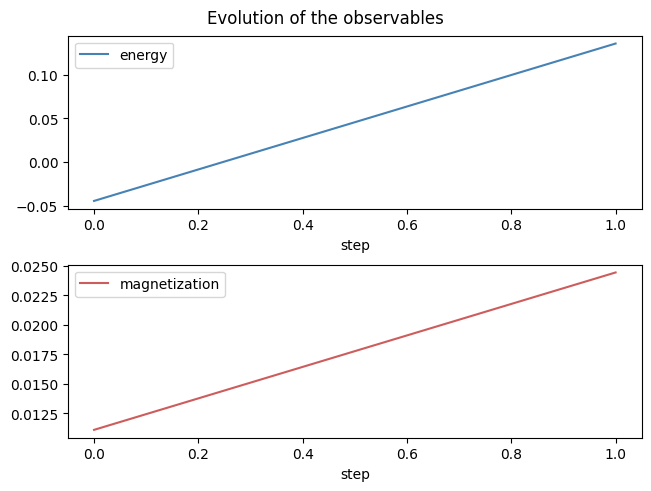

In [44]:
ising = Ising(L=30, T=3, N_eq=300, N_mcs=0, spin_init='random', sample_spin=True)
ising.initialize()
ising.ising_driver()
ising.animate_spin(ising.spin_filename, 'spin_anim_disordered.gif')

fig, axs = plt.subplots(nrows=2, layout="constrained")
fig.suptitle('Evolution of the observables')
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')